In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.tools import eval_measures
from sklearn.linear_model import LinearRegression
from haversine import haversine, Unit
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
import scipy

<h2>Clean Airport Data</h2>

In [2]:
raw = pd.read_csv('Airports2.csv')
raw.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [3]:
cleaned = raw.drop_duplicates('Origin_airport')
cleaned = cleaned[['Origin_airport','Origin_population']]
cleaned = cleaned.set_index('Origin_airport')
cleaned.head()

,Origin_population
Origin_airport,
MHK,122049
EUG,284093
MFR,147300
SEA,5154164
PDX,1534762


In [4]:
raw = pd.read_csv('q3_2019.csv')
raw.head()

,MARKET_COUPONS,ORIGIN,DEST,TK_CARRIER_GROUP,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,Unnamed: 7
0,1,ORD,CLT,AA,23.0,180.5,599.0,NaN
1,1,CLT,ORD,AA,5.0,181.0,599.0,NaN
2,1,ORD,CLT,AA,5.0,181.0,599.0,NaN
3,1,CLT,ORD,AA,54.0,181.5,599.0,NaN
4,1,ORD,CLT,AA,54.0,181.5,599.0,NaN


In [5]:
pax = raw[['ORIGIN','PASSENGERS']].groupby('ORIGIN').sum()
wtavg = lambda x: np.average(x.ORIGIN[:, :2], weights = x.PASSENGERS, axis = 0)
q = raw[['ORIGIN','MARKET_COUPONS','MARKET_DISTANCE','PASSENGERS','MARKET_FARE']].groupby('ORIGIN').apply(lambda x: np.average(x, weights = x.PASSENGERS, axis = 0))
weighted_grouped = pd.DataFrame(q).apply(lambda x: x.to_list())
weighted_grouped.columns = ['vals']
sorted_wg = pd.DataFrame(weighted_grouped.vals.tolist(), index= weighted_grouped.index)
sorted_wg.columns = ['market_coupons','market_distance','passengers','market_fare']
sorted_wg = sorted_wg[['market_coupons','market_distance','market_fare']]
airport_data = sorted_wg.join(pax)
airport_data = airport_data[airport_data['PASSENGERS'] > 1000]
airport_data.join(cleaned, how='left').to_csv('airports_new.csv')
airport_data.join(cleaned, how='left').head()

,market_coupons,market_distance,market_fare,PASSENGERS,Origin_population
ORIGIN,,,,,
ABE,1.490420,1033.379959,185.441812,11796.0,712594.0
ABI,2.040907,1083.881715,271.837137,2029.0,152888.0
ABQ,1.504314,1116.205418,200.709669,65491.0,834685.0
ACK,1.350364,577.105188,228.857112,6322.0,NaN
ACT,2.058899,1032.135083,267.283835,1562.0,191064.0


<p>Unfortunately, this dataset did not contain population data for every city (for example ACK (Nantucket) above). As a result, for these cities, I manually entered 2019 estimates of the metro area populations for these cities</p>

<h2>Joining Nonstop Routes with Airport Data</h2>

In [6]:
airports = pd.read_csv('airports.csv') #import airports csv generated in other file
codes = pd.read_csv('airport-codes_csv.csv') #and airport codes!

In [7]:
nonstops = pd.read_csv('nonstops.csv') #cleaned CSV with all nonstop itineraries in Q3 2019
all_flights = pd.read_csv('all.csv') #similarly importing all itineraries, cleaned or not

In [8]:
origin_merged = pd.merge(nonstops,airports,left_on = 'origin', right_on = 'ORIGIN',suffixes = ('_route',''))
merged = pd.merge(origin_merged,airports,left_on = 'dest', right_on = 'ORIGIN',suffixes = ('_origin','_dest'))

In [9]:
merged = merged[['origin','dest','market_distance_route','market_fare_route','PASSENGERS_route','market_coupons_origin','market_distance_origin','market_fare_origin','PASSENGERS_origin','Origin_population_origin','market_coupons_dest','market_distance_dest','market_fare_dest','PASSENGERS_dest','Origin_population_dest']]
merged.head()

,origin,dest,market_distance_route,market_fare_route,PASSENGERS_route,market_coupons_origin,market_distance_origin,market_fare_origin,PASSENGERS_origin,Origin_population_origin,market_coupons_dest,market_distance_dest,market_fare_dest,PASSENGERS_dest,Origin_population_dest
0,ABE,ATL,692.0,231.733727,542.0,1.490420,1033.379959,185.441812,11796,712594,1.104893,910.687864,188.711991,448391,3087755
1,ABQ,ATL,1269.0,262.495056,718.0,1.504314,1116.205418,200.709669,65491,834685,1.104893,910.687864,188.711991,448391,3087755
2,ACY,ATL,679.0,50.621531,1261.0,1.027258,855.227517,61.978701,10786,236224,1.104893,910.687864,188.711991,448391,3087755
3,ALB,ATL,853.0,230.006320,1155.0,1.619641,1305.322100,228.938693,37625,819105,1.104893,910.687864,188.711991,448391,3087755
4,AUS,ATL,813.0,141.007882,5869.0,1.342153,1191.393869,178.742280,189342,874516,1.104893,910.687864,188.711991,448391,3087755


<AxesSubplot:>

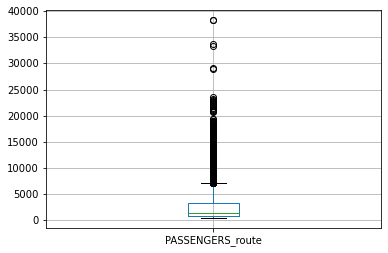

In [10]:
merged.boxplot('PASSENGERS_route')

<p>We see a lot of variation / outliers here -- note the average route box stops at about 3000 passengers, but there are many other more populous routes that act as outliers. Including these outlier airports negatively affects the model's accuracy due to the fact that there are so few of them, so we exclude any routes from the model with fewer than 7800 ten percent passengers in a quarter (roughly any flights with more than 850 PDEW).</p>

<h2>Building The Model</h2>

In [99]:
origin_merged = pd.merge(nonstops,airports,left_on = 'origin', right_on = 'ORIGIN',suffixes = ('_route',''))
merged = pd.merge(origin_merged,airports,left_on = 'dest', right_on = 'ORIGIN',suffixes = ('_origin','_dest'))

merged = merged[merged['PASSENGERS_route'] < 35000]

#we choose these as the variables we wish to fit our model with

y = merged['PASSENGERS_route']
X = merged[['market_distance_route','market_fare_origin','market_coupons_origin','market_distance_origin','PASSENGERS_origin','market_fare_dest','market_coupons_dest','market_distance_dest','PASSENGERS_dest']]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

#we use a Poisson distribution to avoid negative values for small predicted flights!

model = sm.GLM(y_train, X_train, hasconst = True, family=sm.families.Poisson())

results = model.fit()

y_est_tr = results.predict(X_train)
y_est_te = results.predict(X_test)

training_MSE = eval_measures.mse(y_train,y_est_tr)
testing_MSE = eval_measures.mse(y_test,y_est_te)

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       PASSENGERS_route   No. Observations:                 3055
Model:                            GLM   Df Residuals:                     3045
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3969e+06
Date:                Wed, 21 Apr 2021   Deviance:                   2.7655e+06
Time:                        14:26:24   Pearson chi2:                 3.07e+06
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     11

In [100]:
print(training_MSE,testing_MSE)

4334209.399778294 4848131.0344410855


<p>We see similar MSEs for training and testing, indicating that we have produced a decent model.</p>
<p>Next, we run this model for a variety of different test/train samples to assess its reproducibility for different cutoffs for max passenger flights.</p>

In [19]:
trainMSE = []
diff = []

for j in [3,8,32,42]:
    origin_merged = pd.merge(nonstops,airports,left_on = 'origin', right_on = 'ORIGIN',suffixes = ('_route',''))
    merged = pd.merge(origin_merged,airports,left_on = 'dest', right_on = 'ORIGIN',suffixes = ('_origin','_dest'))
    inside_MSE = []
    inside_diff = []
    for i in np.linspace(50000,500,100):
        merged = merged[merged['PASSENGERS_route'] < i]

        y = merged['PASSENGERS_route']
        X = merged[['market_distance_route','market_fare_origin','market_coupons_origin','market_distance_origin','PASSENGERS_origin','market_fare_dest','market_coupons_dest','market_distance_dest','PASSENGERS_dest']]
        # X = merged['market_distance_route']

    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = j)


        X_train = sm.add_constant(X_train)
        X_test = sm.add_constant(X_test)

        model = sm.GLM(y_train, X_train, hasconst = True, family=sm.families.Poisson())
        results = model.fit()

        y_est_tr = results.predict(X_train)
        y_est_te = results.predict(X_test)

        training_MSE = eval_measures.mse(y_train,y_est_tr)
        testing_MSE = eval_measures.mse(y_test,y_est_te)
        inside_MSE.append(training_MSE)
        inside_diff.append((testing_MSE - training_MSE) / training_MSE)
    trainMSE.append(inside_MSE)
    diff.append(inside_diff)

Text(0, 0.5, 'Percent Difference')

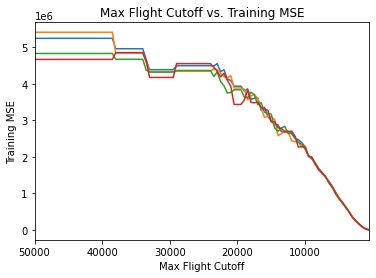

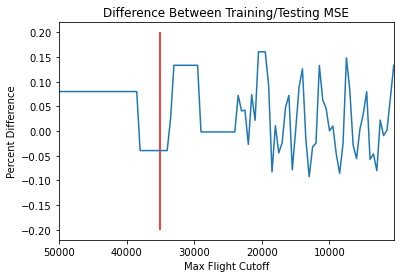

In [61]:
fig, ax = plt.subplots()

ax.plot(np.linspace(50000,500,100),np.array(trainMSE[0]))
ax.plot(np.linspace(50000,500,100),np.array(trainMSE[1]))
ax.plot(np.linspace(50000,500,100),np.array(trainMSE[2]))
ax.plot(np.linspace(50000,500,100),np.array(trainMSE[3]))
ax.set_xlim([50000,500])
plt.title('Max Flight Cutoff vs. Training MSE')
plt.xlabel('Max Flight Cutoff')
plt.ylabel('Training MSE')

fig2, ax2 = plt.subplots()

# ax2.plot(np.linspace(50000,500,100),diff[0])
# ax2.plot(np.linspace(50000,500,100),diff[1])
# ax2.plot(np.linspace(50000,500,100),diff[2])
# ax2.plot(np.linspace(50000,500,100),diff[3])
ax2.plot(np.linspace(50000,500,100),(np.array(diff[0]) + np.array(diff[1]) + np.array(diff[2]) + np.array(diff[3]))  / 4)
ax2.set_xlim([50000,500])
ax2.vlines(35000,-0.2,0.2,colors="red")
plt.title('Difference Between Training/Testing MSE')
plt.xlabel('Max Flight Cutoff')
plt.ylabel('Percent Difference')

<h2>Running The Model For Each Route</h2>

In [101]:
def pax_predict(origin,dest):
    zero = 1.0
    two = (airports[airports['ORIGIN'] == origin]['market_fare'].values[0])
    three = (airports[airports['ORIGIN'] == origin]['market_coupons'].values[0])
    four = (airports[airports['ORIGIN'] == origin]['market_distance'].values[0])
    five = (((airports[airports['ORIGIN'] == origin]['PASSENGERS'].values[0])))
    six = (airports[airports['ORIGIN'] == dest]['market_fare'].values[0])
    seven = (airports[airports['ORIGIN'] == dest]['market_coupons'].values[0])
    eight = (airports[airports['ORIGIN'] == dest]['market_distance'].values[0])
    nine = (((airports[airports['ORIGIN'] == dest]['PASSENGERS'].values[0])))
    
    
    origin_joint = codes[codes['iata_code'] == origin]['coordinates'].values[0].split(', ')
    origin_ll = (float(origin_joint[1]),float(origin_joint[0]))
    ll_out = float(origin_joint[0]),float(origin_joint[1])
    
    dest_joint = codes[codes['iata_code'] == dest]['coordinates'].values[0].split(', ')
    dest_ll = (float(dest_joint[1]),float(dest_joint[0]))
    dest_ll_out = (float(dest_joint[0]),float(dest_joint[1]))
    route_dist = haversine(origin_ll,dest_ll,unit='mi')

    one = (route_dist)
    
    origin_pop = airports[airports['ORIGIN'] == origin]['Origin_population'].values[0]
    dest_pop = airports[airports['ORIGIN'] == dest]['Origin_population'].values[0]
#     print(one,two,three,four,five,six,seven,eight,nine)
    return (results.predict([zero,one,two,three,four,five,six,seven,eight,nine])[0]*10/90,ll_out,dest_ll_out)


#     results.predict([1,1,1,1,1,1,1,1,1,1])[0]

In [103]:
origin_merged = pd.merge(nonstops,airports,left_on = 'origin', right_on = 'ORIGIN',suffixes = ('_route',''))
merged = pd.merge(origin_merged,airports,left_on = 'dest', right_on = 'ORIGIN',suffixes = ('_origin','_dest'))
merged = merged[merged['PASSENGERS_route'] < 35000]

model_output = []

for i in airports.iterrows():
    print(i[1]['ORIGIN'])
    for j in airports.iterrows():
        imd = []
        origin = i[1]['ORIGIN']
        dest = j[1]['ORIGIN']
        pred,oll,dll = pax_predict(origin,dest)
        
        nonstop = nonstops[(nonstops['origin'] == origin) & (nonstops['dest'] == dest)]['PASSENGERS']*(1/9)
        if len(nonstop) == 1:
            nonstop_out = float(nonstop)
        else:
            nonstop_out = None
            
        total = (all_flights[(all_flights['origin'] == origin) & (all_flights['dest'] == dest)]['PASSENGERS']*(1/9))
        if len(total) == 1:
            total_out = float(total)
        else:
            total_out = None
        
        
        model_output.append([origin,dest,pred,nonstop_out,total_out,oll,dll])
        
        
        
#     print(i[1]['ORIGIN'])

ABE
ABI
ABQ
ACK
ACT
ACV
ACY
ADQ
AEX
AGS
ALB
ALW
AMA
ANC
ASE
ATL
ATW
AUS
AVL
AVP
AZA
AZO
BDL
BET
BFL
BGM
BGR
BHM
BIL
BIS
BLI
BLV
BMI
BNA
BOI
BOS
BQK
BQN
BRO
BTR
BTV
BUF
BUR
BWI
BZN
CAE
CAK
CHA
CHO
CHS
CID
CLE
CLL
CLT
CMH
CMI
COD
COS
COU
CPR
CRP
CRW
CSG
CVG
CWA
DAB
DAL
DAY
DCA
DEN
DFW
DHN
DLH
DRO
DSM
DTW
EAT
ECP
EGE
ELM
ELP
ERI
EUG
EVV
EWN
EWR
EYW
FAI
FAR
FAT
FAY
FCA
FLG
FLL
FLO
FNT
FSD
FSM
FWA
GEG
GFK
GJT
GNV
GPT
GRB
GRI
GRK
GRR
GSO
GSP
GTF
GTR
GUM
HHH
HLN
HNL
HOU
HPN
HRL
HSV
HTS
HVN
IAD
IAG
IAH
ICT
IDA
ILM
IND
ISN
ISP
ITH
ITO
JAC
JAN
JAX
JFK
JLN
JNU
KOA
KTN
LAN
LAS
LAW
LAX
LBB
LBE
LCH
LCK
LEX
LFT
LGA
LGB
LIH
LIT
LNK
LRD
LSE
LWS
LYH
MAF
MBS
MCI
MCO
MDT
MDW
MEM
MFE
MFR
MGM
MHK
MHT
MIA
MKE
MLB
MLI
MLU
MOB
MOT
MQT
MRY
MSN
MSO
MSP
MSY
MTJ
MVY
MYR
OAJ
OAK
OGG
OKC
OMA
OME
ONT
ORD
ORF
ORH
PAE
PBG
PBI
PDX
PGD
PGV
PHF
PHL
PHX
PIA
PIE
PIH
PIT
PLN
PNS
PSC
PSE
PSM
PSP
PUW
PVD
PVU
PWM
RAP
RDD
RDM
RDU
RFD
RIC
RNO
ROA
ROC
ROW
RST
RSW
SAF
SAN
SAT
SAV
SBA
SBN
SBP
SBY
SCC
SCE
SCK
SDF
SEA
SFB
SFO
SGF
SHV


In [104]:
model_output = pd.DataFrame(model_output)
model_output.columns = ['origin','dest','pred','nonstop','total','oll','dll']
model_output.head()

,origin,dest,pred,nonstop,total,oll,dll
0,ABE,ABE,43.451615,NaN,NaN,"(-75.44080352783203, 40.652099609375)","(-75.44080352783203, 40.652099609375)"
1,ABE,ABI,6.241176,NaN,0.222222,"(-75.44080352783203, 40.652099609375)","(-99.68190002440001, 32.4113006592)"
2,ABE,ABQ,24.279265,NaN,4.222222,"(-75.44080352783203, 40.652099609375)","(-106.609001, 35.040199)"
3,ABE,ACK,36.413790,NaN,0.111111,"(-75.44080352783203, 40.652099609375)","(-70.06020355, 41.25310135)"
4,ABE,ACT,5.993340,NaN,NaN,"(-75.44080352783203, 40.652099609375)","(-97.23049926757812, 31.611299514770508)"


In [105]:
model_output.to_csv('model_output_25k.csv')

<h2>Attach Lattitude/Longitude To Airport Data</h2>

In [ ]:
airports_withloc = pd.merge(airports,codes,left_on='ORIGIN',right_on='iata_code')[['ORIGIN','market_distance','market_fare','PASSENGERS','Origin_population','coordinates']]

In [ ]:
latandlong = airports_withloc['coordinates'].str.split(', ',n=1,expand=True)

In [ ]:
airports_withloc['long'] = latandlong[0].astype(float)
airports_withloc['lat'] = latandlong[1].astype(float)

In [ ]:
airports_withloc

In [ ]:
airports_withloc[['ORIGIN','market_distance','market_fare','PASSENGERS','Origin_population','long','lat']].to_csv('airports_withloc.csv',index=False)